# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [4]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [5]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [6]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [7]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
print('Income:')
print(f'산술평균: {df['Income'].mean():.2f}')
print(f'중앙값: {df['Income'].median():.2f}')
print(f'최빈값: {df['Income'].mode().values}')
print(f'절사평균 (5%): {stats.trim_mean(df['Income'], 0.1):.2f}') # 상,하 5% 제거 후 평균

print('\nTotal_Spending:')
print(f'산술평균: {df['Total_Spending'].mean():.2f}')
print(f'중앙값: {df['Total_Spending'].median():.2f}')
print(f'최빈값: {df['Total_Spending'].mode().values}')
print(f'절사평균 (5%): {stats.trim_mean(df['Total_Spending'], 0.1):.2f}')

print('\nAge:')
print(f'산술평균: {df['Age'].mean():.2f}')
print(f'중앙값: {df['Age'].median():.2f}')
print(f'최빈값: {df['Age'].mode().values}')
print(f'절사평균 (5%): {stats.trim_mean(df['Age'], 0.1):.2f}')

Income:
산술평균: 51952.61
중앙값: 51381.50
최빈값: [51381.5]
절사평균 (5%): 51730.80

Total_Spending:
산술평균: 605.99
중앙값: 396.50
최빈값: [46]
절사평균 (5%): 526.63

Age:
산술평균: 55.10
중앙값: 54.00
최빈값: [48]
절사평균 (5%): 55.04


In [8]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
print('Income:')
print(f'분산: {df['Income'].var(ddof=1):.4f}')
print(f'표준편차: {df['Income'].std():.4f}')
print(f"IQR: {df['Income'].quantile(0.75) - df['Income'].quantile(0.25):.4f}")
print(f"CV(%): {df['Income'].std() / df['Income'].mean() * 100:.4f}")

print('\nTotal_Spending:')
print(f'분산: {df['Total_Spending'].var(ddof=1):.4f}')
print(f'표준편차: {df['Total_Spending'].std():.4f}')
print(f"IQR: {df['Total_Spending'].quantile(0.75) - df['Total_Spending'].quantile(0.25):.4f}")
print(f"CV(%): {df['Total_Spending'].std() / df['Total_Spending'].mean() * 100:.4f}")

print('\nAge:')
print(f'분산: {df['Age'].var(ddof=1):.4f}')
print(f'표준편차: {df['Age'].std():.4f}')
print(f"IQR: {df['Age'].quantile(0.75) - df['Age'].quantile(0.25):.4f}")
print(f"CV(%): {df['Age'].std() / df['Age'].mean() * 100:.4f}")

Income:
분산: 458450912.6926
표준편차: 21411.4669
IQR: 32773.2500
CV(%): 41.2135

Total_Spending:
분산: 362241.6660
표준편차: 601.8652
IQR: 976.5000
CV(%): 99.3199

Age:
분산: 136.9668
표준편차: 11.7033
IQR: 18.0000
CV(%): 21.2393


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

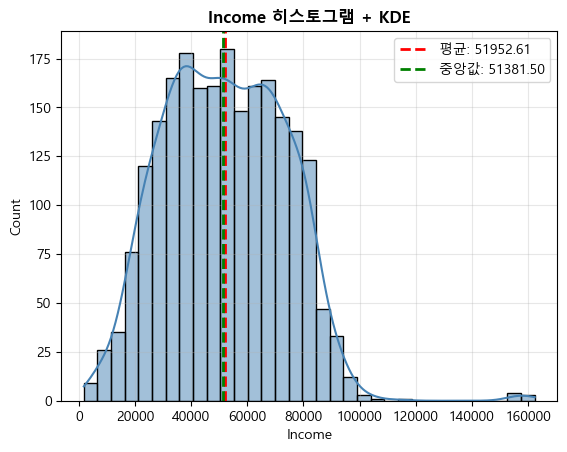

In [9]:
# TODO 1-2(a): Income 히스토그램 + KDE

sns.histplot(data=df, x="Income", kde=True, color='steelblue')

# 평균/중앙값 계산
mean_val = df["Income"].mean()
median_val = df["Income"].median()

# 평균선 (빨강)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_val:.2f}')

#중앙값 선 (초록)
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'중앙값: {median_val:.2f}')

plt.title("Income 히스토그램 + KDE", fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

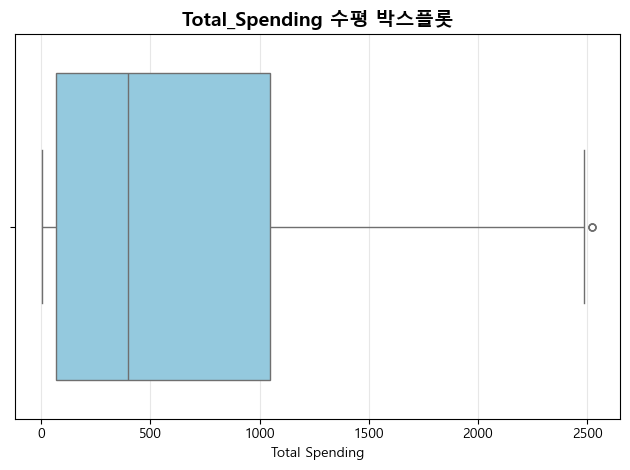

Q1 (25%): 69.00
Q3 (75%): 1045.50
IQR: 976.50
Total_Spending IQR 이상치 개수: 3


In [81]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치

# 수평 박스플롯
sns.boxplot(data=df, x="Total_Spending", color="skyblue", fliersize=5)

plt.title("Total_Spending 수평 박스플롯", fontsize=14, fontweight='bold')
plt.xlabel("Total Spending")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# IQR 기준 이상치
Q1 = df["Total_Spending"].quantile(0.25)
Q3 = df["Total_Spending"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["Total_Spending"] < lower_bound) | (df["Total_Spending"] > upper_bound)]

print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Total_Spending IQR 이상치 개수: {len(outliers)}")

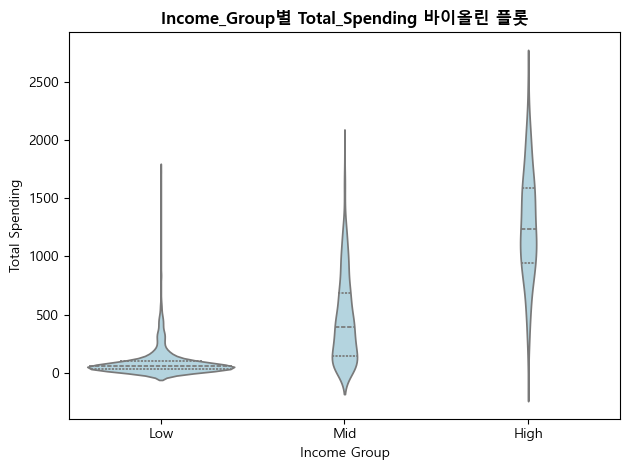

In [10]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
# - **(c)** Income_Group별 Total_Spending 바이올린 플롯

sns.violinplot(data=df, x='Income_Group', y='Total_Spending', color='lightblue', inner='quartile')
plt.xlabel('Income Group')
plt.ylabel('Total Spending')
plt.title('Income_Group별 Total_Spending 바이올린 플롯', fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [11]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
for col in spending_cols:
    print(f"{col}")
    print(f"왜도: {df[col].skew():.4f}")
    print(f"첨도: {df[col].kurt():.4f}")
    print()

MntWines
왜도: 1.1760
첨도: 0.6005

MntFruits
왜도: 2.1042
첨도: 4.0698

MntMeatProducts
왜도: 2.0853
첨도: 5.5301

MntFishProducts
왜도: 1.9200
첨도: 3.0960

MntSweetProducts
왜도: 2.1357
첨도: 4.3721

MntGoldProds
왜도: 1.8851
첨도: 3.5583



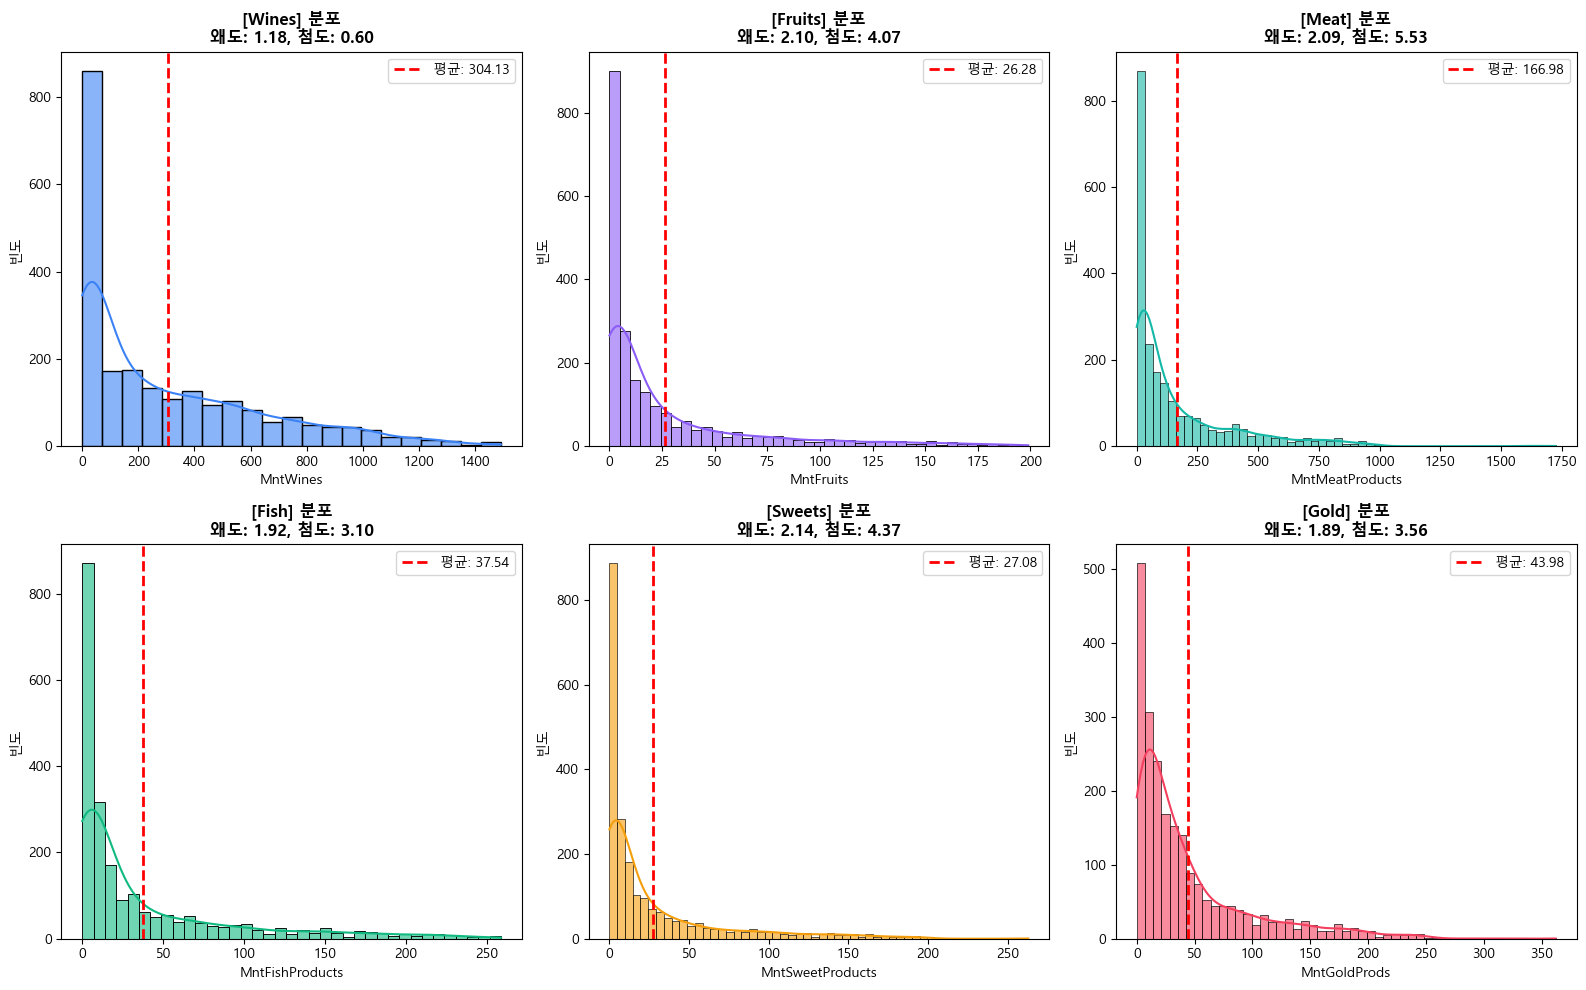

,왜도,첨도,왜도 해석,첨도 해석
Category,,,,
Wines,1.1760,0.6005,오른쪽 꼬리,꼬리가 두꺼움
Fruits,2.1042,4.0698,오른쪽 꼬리,꼬리가 두꺼움
Meat,2.0853,5.5301,오른쪽 꼬리,꼬리가 두꺼움
Fish,1.9200,3.0960,오른쪽 꼬리,꼬리가 두꺼움
Sweets,2.1357,4.3721,오른쪽 꼬리,꼬리가 두꺼움
Gold,1.8851,3.5583,오른쪽 꼬리,꼬리가 두꺼움


In [12]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten() # 2D 배열을 1D로 변환

# zip을 사용해 컬럼명, 출력용 이름, 색상을 동시에 순회
for i, (col, name, color) in enumerate(zip(spending_cols, spending_names, hist_colors)):
    ax = axes[i]
    
    # 히스토그램 + KDE (지정된 color 사용)
    sns.histplot(data=df, x=col, kde=True, color=color, ax=ax, edgecolor='black', alpha=0.6)
    
    # 통계치 계산
    mean_val = df[col].mean()
    skew_val = df[col].skew()
    kurt_val = df[col].kurt()
    
    # 평균선 추가
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_val:.2f}')
    
    # 제목 설정 (지정된 별칭 사용)
    ax.set_title(f'[{name}] 분포\n왜도: {skew_val:.2f}, 첨도: {kurt_val:.2f}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도')
    ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2. 통계 요약 테이블 (해석 포함)
# ---------------------------------------------------------
stats_data = []
for col, name in zip(spending_cols, spending_names):
    stats_data.append({
        'Category': name,
        '왜도': round(df[col].skew(), 4),
        '첨도': round(df[col].kurt(), 4)
    })

spend_stats = pd.DataFrame(stats_data).set_index('Category')

# 해석 컬럼 추가
def interpret_skew(value):
    if value > 0:
        return '오른쪽 꼬리'
    elif value < 0:
        return '왼쪽 꼬리'
    else:
        return '대칭적'

def interpret_kurt(value):
    if value > 0:
        return '꼬리가 두꺼움'
    elif value < 0:
        return '꼬리가 얇음'
    else:
        return '정규분포와 동일'
    
spend_stats['왜도 해석'] = spend_stats['왜도'].apply(interpret_skew)
spend_stats['첨도 해석'] = spend_stats['첨도'].apply(interpret_kurt)

display(spend_stats)

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [13]:
# TODO 1-4: 비즈니스 인사이트 정리
print('1. 고객 특성 요약')
print('연령: 평균 약 55세, 변동계수 가장 작음(약 21.24%)')
print('소득: 평균 약 51953, 중앙값 약 51382, 히스토그램+KDE 그래프 확인 시 정규분포에 근사')
print('소비 특성: 평균 약 606, 중앙값 약 397, 변동계수 99.3% 로 편차가 심함')

1. 고객 특성 요약
연령: 평균 약 55세, 변동계수 가장 작음(약 21.24%)
소득: 평균 약 51953, 중앙값 약 51382, 히스토그램+KDE 그래프 확인 시 정규분포에 근사
소비 특성: 평균 약 606, 중앙값 약 397, 변동계수 99.3% 로 편차가 심함


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [14]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = df['Response'].mean()

# scipy.stats를 이용한 이항 분포
binom_dist = stats.binom(n = n_trial, p = p)

# (a) 10명 중 정확히 2명이 수락할 확률
p_exactly_2 = binom_dist.pmf(2)
print(f"(a) P(X = 2) = {p_exactly_2:.4f}")

# (b) 10명 중 3명 이상이 수락할 확률
p_at_least_3 = binom_dist.sf(2)
print(f"(b) P(X ≥ 3) = {p_at_least_3:.4f}")

(a) P(X = 2) = 0.2752
(b) P(X ≥ 3) = 0.1782


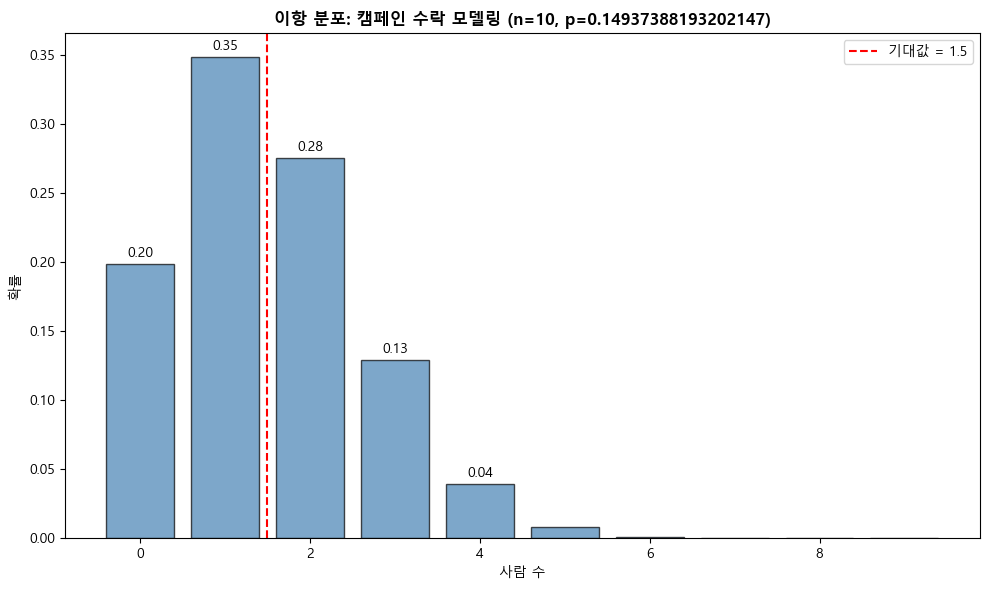

In [15]:
# TODO 2-1(c): 이항분포 PMF 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# PMF 그래프
k = np.arange(0, 10)
pmf = binom_dist.pmf(k)
ax.bar(k, pmf, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(n_trial * p, color='red', linestyle='--',
                label=f'기대값 = {n_trial * p:.1f}')
ax.set_xlabel('사람 수')
ax.set_ylabel('확률')
ax.set_title(f'이항 분포: 캠페인 수락 모델링 (n=10, p={p})', fontweight='bold')
ax.legend() # 범례 표시

#각 막대별로 확률값 그리기
for x, prob in zip(k, pmf) :
    if prob > 0.01:
        ax.text(x, prob + 0.005, f'{prob:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [16]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100
binom_campaign = stats.binom(n=n_campaign, p=p)

# - **(d)** n=100 으로 확장 — 세 가지 질문
#   - **기대 수락자 수**: E(X) 계산
#   - **15명 이상 수락 확률**: P(X ≥ 15) 계산
#   - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색
# (1) 100명 발송 시 기대 수락자
expected_campaign = n_campaign * p
print(f"E(X) = {expected_campaign:.2f}")

# (2) 15명 이상 수락 확률: P(X ≥ 15) = P(X > 14)
p_at_least_15 = binom_campaign.sf(14)
print(f"P(X ≥ 15) = {p_at_least_15:.4f}")

# (3) 90% 보장 최소 수락 수: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색
k_min_guaranteed = binom_campaign.ppf(0.10)
print(f"90% 보장 최소 수락 수 = {k_min_guaranteed}")



E(X) = 14.94
P(X ≥ 15) = 0.5358
90% 보장 최소 수락 수 = 10.0


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [17]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lambda_web = web_visits.mean()
var_web = web_visits.var()

print(f"람다 추정: {lambda_web:.4f}")
print(f"분산: {var_web:.4f}")

람다 추정: 5.3189
분산: 5.8898


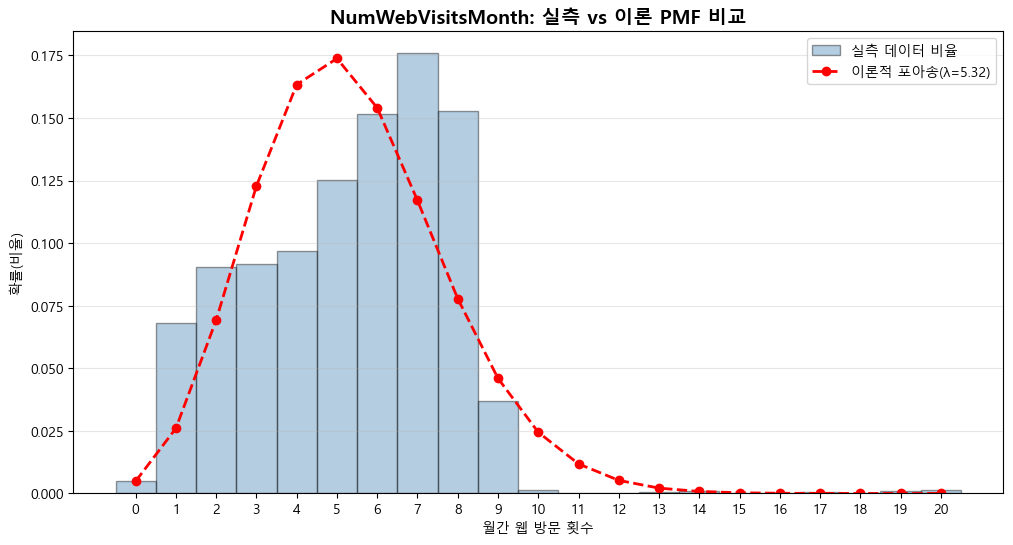

In [18]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
plt.figure(figsize=(12, 6))

bins = np.arange(0, web_visits.max() + 2) - 0.5
plt.hist(web_visits, bins=bins, density=True, alpha=0.4, color='steelblue', 
         edgecolor='black', label='실측 데이터 비율')


x_pts = np.arange(0, web_visits.max() + 1)
theory_pmf = stats.poisson.pmf(x_pts, mu=lambda_web)
plt.plot(x_pts, theory_pmf, 'ro--', linewidth=2, markersize=6, label=f'이론적 포아송(λ={lambda_web:.2f})')

plt.title('NumWebVisitsMonth: 실측 vs 이론 PMF 비교', fontsize=14, fontweight='bold')
plt.xlabel('월간 웹 방문 횟수')
plt.ylabel('확률(비율)')
plt.xticks(x_pts)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [19]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

p_heavy = stats.poisson.sf(heavy_threshold - 1, mu=lambda_web)

k_server = stats.poisson.ppf(0.95, mu=lambda_web)

print(f"월 10회 이상 방문 확률: {p_heavy*100:.2f}%")
print(f"서버 용량 계획(상위 5% 기준): 월 {int(k_server)}회 방문까지 대응 권장")

월 10회 이상 방문 확률: 4.49%
서버 용량 계획(상위 5% 기준): 월 9회 방문까지 대응 권장


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [20]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

mu_inc = df['Income'].mean()
std_inc = df['Income'].std()
norm_dist = stats.norm(loc=mu_inc, scale=std_inc)

# P(Income<30000)
print(f"P(Income<30000) = {norm_dist.cdf(30000):.4f}")

# P(Income>80000)
print(f"P(Income>80000) = {norm_dist.sf(80000):.4f}")

# 상위 10% 소득 기준값 계산
# 이론 확률
print(f"상위 10% 소득 기준값(이론 확률) = {norm_dist.ppf(0.90):.1f}")

# 실측 비율
print(f"상위 10% 소득 기준값(실측 비율) = {df['Income'].quantile(0.90)}")

P(Income<30000) = 0.1526
P(Income>80000) = 0.0951
상위 10% 소득 기준값(이론 확률) = 79392.5
상위 10% 소득 기준값(실측 비율) = 79747.5


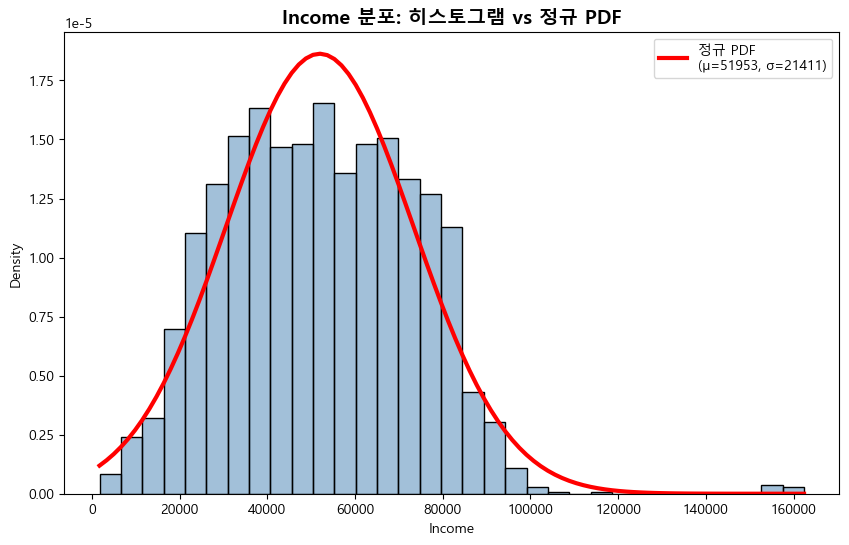

In [21]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
plt.figure(figsize=(10, 6))

sns.histplot(df['Income'], kde=False, stat="density", color='steelblue', alpha=0.5)

x_axis = np.linspace(df['Income'].min(), df['Income'].max(), 100)
plt.plot(x_axis, norm_dist.pdf(x_axis), 'r-', lw=3, label=f'정규 PDF\n(μ={mu_inc:.0f}, σ={std_inc:.0f})')

plt.title('Income 분포: 히스토그램 vs 정규 PDF', fontsize=14, fontweight='bold')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

In [22]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
# 상위 5% (누적 95%)
print(f"VIP 기준선 (상위 5%): {norm_dist.ppf(0.95):.2f} 이상")
# 하위 10% (누적 10%)
print(f"할인 대상 기준선 (하위 10%): {norm_dist.ppf(0.10):.2f} 이하")

VIP 기준선 (상위 5%): 87171.34 이상
할인 대상 기준선 (하위 10%): 24512.72 이하


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [23]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE

spending = df['Total_Spending']
n = len(spending)
x_bar = spending.mean()
se = spending.sem()  # 표준오차 (s / sqrt(n))

for confidence in [0.90, 0.95, 0.99]:
    ci = stats.t.interval(confidence, n-1, loc=x_bar, scale=se)
    print(f"{int(confidence*100)}% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")

90% CI: [585.04, 626.93]
95% CI: [581.03, 630.95]
99% CI: [573.17, 638.80]


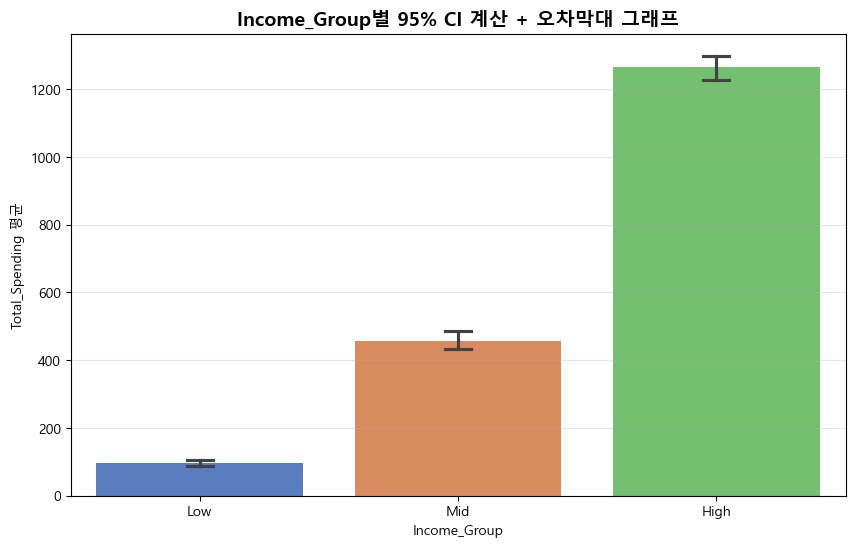

In [24]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='Income_Group', y='Total_Spending', 
            palette='muted', capsize=0.1, errorbar=('ci', 95))

plt.title('Income_Group별 95% CI 계산 + 오차막대 그래프', fontsize=14, fontweight='bold')
plt.xlabel('Income_Group')
plt.ylabel('Total_Spending 평균')
plt.grid(axis='y', alpha=0.3)
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [25]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_val = stats.ttest_ind(no_child, yes_child, equal_var=False)

# Cohen's d 계산
# 두 집단의 표준편차를 통합한 합산 표준편차 사용
n1, n2 = len(no_child), len(yes_child)
s1, s2 = no_child.std(), yes_child.std()
pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
cohens_d = (no_child.mean() - yes_child.mean()) / pooled_std

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val}")
print(f"Cohen's d: {cohens_d:.4f}")

# 가설 검정 결과 해석
alpha = 0.05
if p_val < alpha:
    print("결과: 귀무가설(H0) 기각 → 자녀 유무에 따른 소비 금액 차이가 통계적으로 유의미하다.")
else:
    print("결과: 귀무가설(H0) 채택 → 자녀 유무에 따른 소비 금액 차이가 유의미하지 않다.")
    
# Cohen's d 효과 크기 해석
if abs(cohens_d) < 0.5:
    effect = "작은"
elif abs(cohens_d) < 0.8:
    effect = "중간"
else:
    effect = "큰"
print(f"효과 크기: {effect} 효과")

t-statistic: 24.9889
p-value: 6.321230429385628e-105
Cohen's d: 1.3599
결과: 귀무가설(H0) 기각 → 자녀 유무에 따른 소비 금액 차이가 통계적으로 유의미하다.
효과 크기: 큰 효과


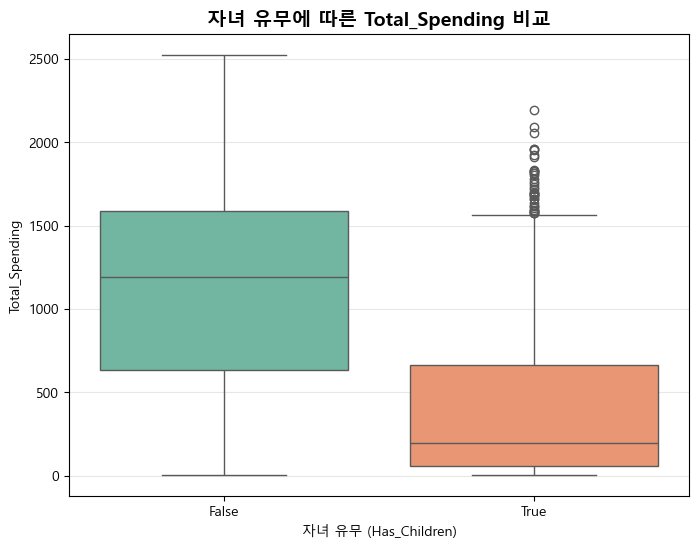

In [26]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(8, 6))

sns.boxplot(data=df, x='Has_Children', y='Total_Spending', palette='Set2')

plt.title('자녀 유무에 따른 Total_Spending 비교', fontsize=14, fontweight='bold')
plt.xlabel('자녀 유무 (Has_Children)')
plt.ylabel('Total_Spending')
plt.grid(axis='y', alpha=0.3)
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [27]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat
t_stat, p_val = stats.ttest_rel(wines, meat)
cohens_d_paired = diff.mean() / diff.std()

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val}")
print(f"Cohen's d: {abs(cohens_d_paired):.4f}")


# 가설 검정 결과 해석
alpha = 0.05
if p_val < alpha:
    print("결과: 귀무가설(H0) 기각 → 와인과 육류 간 소비에 유의미한 차이가 있다.")
else:
    print("결과: 귀무가설(H0) 채택 → 와인과 육류 간 소비에 유의미한 차이가 없다.")
    
# Cohen's d 효과 크기 해석
if abs(cohens_d) < 0.5:
    effect = "작은"
elif abs(cohens_d) < 0.8:
    effect = "중간"
else:
    effect = "큰"
print(f"효과 크기: {effect} 효과")


t-statistic: 23.0929
p-value: 5.391926544698085e-106
Cohen's d: 0.4884
결과: 귀무가설(H0) 기각 → 와인과 육류 간 소비에 유의미한 차이가 있다.
효과 크기: 큰 효과


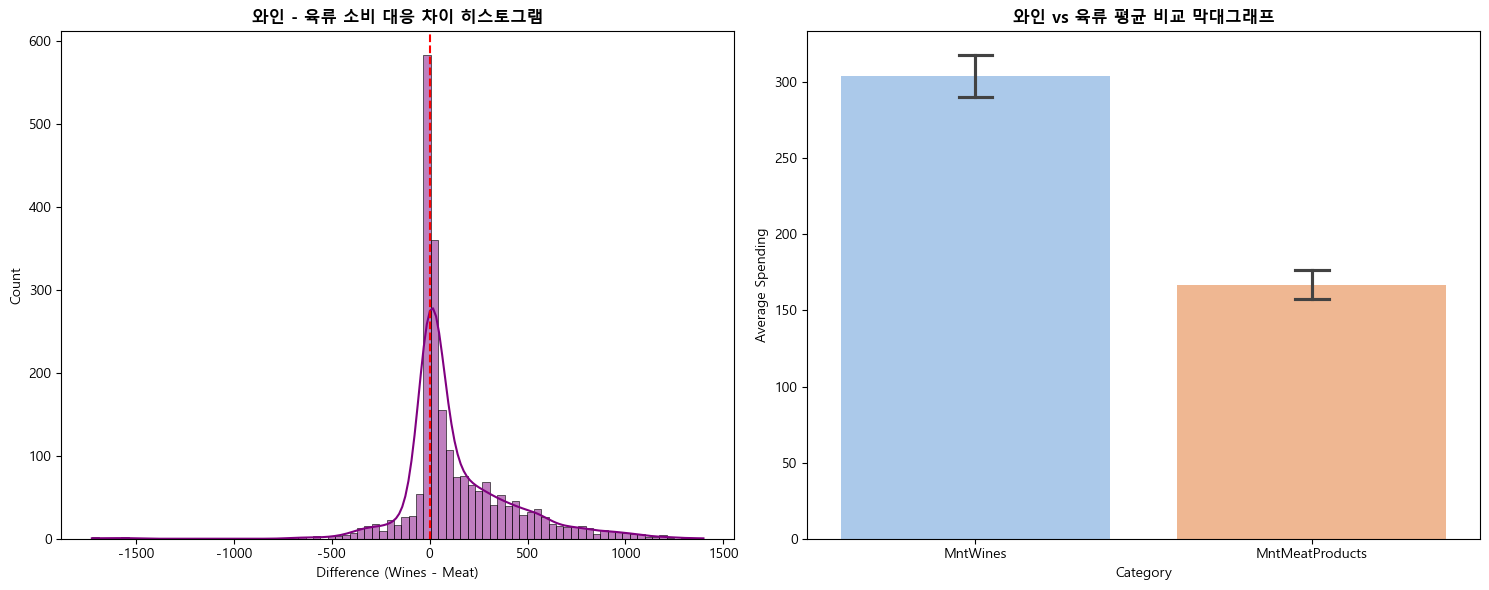

In [28]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# (1) 대응 차이 히스토그램
sns.histplot(diff, kde=True, ax=axes[0], color='purple')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_title('와인 - 육류 소비 대응 차이 히스토그램', fontweight='bold')
axes[0].set_xlabel('Difference (Wines - Meat)')

# (2) 카테고리별 평균 비교 막대그래프
comparison_df = df[['MntWines', 'MntMeatProducts']].melt(var_name='Category', value_name='Spending')
sns.barplot(data=comparison_df, x='Category', y='Spending', ax=axes[1], palette='pastel', capsize=0.1)
axes[1].set_title('와인 vs 육류 평균 비교 막대그래프', fontweight='bold')
axes[1].set_ylabel('Average Spending')

plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [29]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
current_power = power_analysis.solve_power(
    effect_size = abs(cohens_d), 
    nobs1 = n1, 
    ratio = n2 / n1, 
    alpha = 0.05, 
    alternative = 'two-sided'
)
print(f"검정력(Power) = {current_power}") # nan이 나오는 이유??

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
required_n = power_analysis.solve_power(
    effect_size=0.2, 
    power=0.8, 
    alpha=0.05, 
    ratio=1.0, 
    alternative='two-sided'
)
print(f"작은 효과(d=0.2) 탐지를 위해 필요한 그룹당 표본 크기: {np.ceil(required_n):.0f}명")

검정력(Power) = nan
작은 효과(d=0.2) 탐지를 위해 필요한 그룹당 표본 크기: 394명


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [30]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

edu_data = [df[df['Education_Group'] == g]['Total_Spending'] for g in edu_groups]

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
for group_name, data in zip(edu_groups, edu_data):
    n = len(data)
    shapiro_stat, p_val = stats.shapiro(data)
    
    print(f"Group: {group_name}")
    print(f"n={n}")
    print(f"p-value={p_val}")
    
    if p_val < 0.05:
        print(f"→ 정규성 기각, 하지만 n이 {n}이므로 ANOVA 수행 가능(CLT)")
    else:
        print(f"→ 정규성 만족")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
print("-" * 60)
levene_stat, levene_p = stats.levene(*edu_data, center='median')
print(f"Levene 등분산 검정 p-value: {levene_p}")

if levene_p < 0.05:
    print("→ 등분산 기각: 그룹 간 분산이 다르므로 Welch's ANOVA 사용")
    use_welch = True
else:
    print("→ 등분산 : 그룹 간 분산이 비슷하므로 ANOVA 사용")
    use_welch = False

Group: Undergraduate
n=255
p-value=5.543648052614619e-19
→ 정규성 기각, 하지만 n이 255이므로 ANOVA 수행 가능(CLT)
Group: Graduate
n=1126
p-value=3.561909628976696e-29
→ 정규성 기각, 하지만 n이 1126이므로 ANOVA 수행 가능(CLT)
Group: Postgraduate
n=855
p-value=1.7757879312718283e-25
→ 정규성 기각, 하지만 n이 855이므로 ANOVA 수행 가능(CLT)
------------------------------------------------------------
Levene 등분산 검정 p-value: 1.8306692793099772e-06
→ 등분산 기각: 그룹 간 분산이 다르므로 Welch's ANOVA 사용


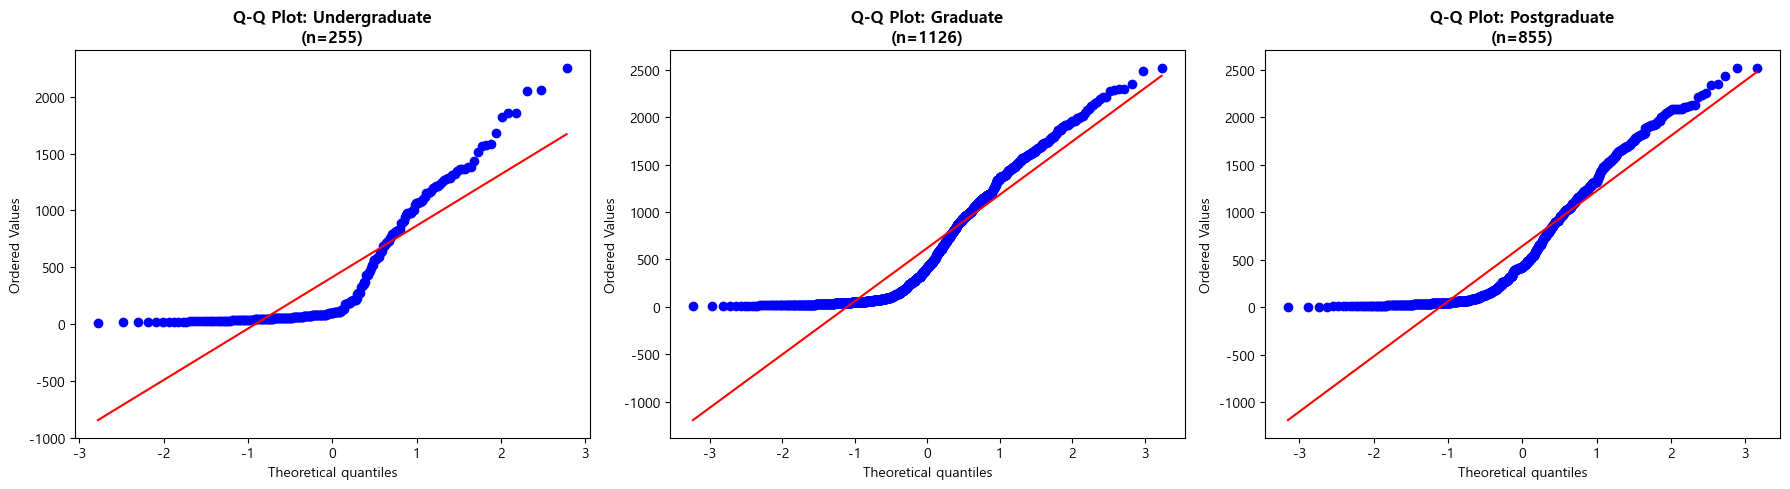

In [31]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (group_name, data) in enumerate(zip(edu_groups, edu_data)):
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {group_name}\n(n={len(data)})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [99]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
if use_welch:
    # Welch's ANOVA
    res_anova = pg.welch_anova(data=df, dv='Total_Spending', between='Education_Group')
    p_val_anova = res_anova['p-unc'].values[0]
    print("검정: Welch's ANOVA")
else:
    # 일반 One-way ANOVA
    res_anova = pg.anova(data=df, dv='Total_Spending', between='Education_Group')
    p_val_anova = res_anova['p-unc'].values[0]
    print("검정: One-way ANOVA")

print(res_anova)

# 비모수 검정 (Kruskal-Wallis) 병행
res_kruskal = pg.kruskal(data=df, dv='Total_Spending', between='Education_Group')
print(f"\n[비모수 검정 결과] Kruskal-Wallis p-value: {res_kruskal['p-unc'].values[0]}")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
eta_sq = res_anova['np2'].values[0] if 'np2' in res_anova.columns else res_anova['partial_eta2'].values[0]

# 일반 ANOVA 테이블 정보를 이용한 ω² 계산
aov = pg.anova(data=df, dv='Total_Spending', between='Education_Group', detailed=True)

ss_between = aov.iloc[0, 1]
ss_resid   = aov.iloc[1, 1]
df_between = aov.iloc[0, 2]
ms_within  = aov.iloc[1, 3]
ss_total   = ss_between + ss_resid

eta_sq = ss_between / ss_total

omega_sq = (ss_between - (df_between * ms_within)) / (ss_total + ms_within)

print(f"[전체 효과 크기 결과]")
print(f"- η² (Eta Squared): {eta_sq:.4f}")
print(f"- ω² (Omega Squared): {omega_sq:.4f}")


검정: Welch's ANOVA
            Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137

[비모수 검정 결과] Kruskal-Wallis p-value: 1.1207736037427136e-08
[전체 효과 크기 결과]
- η² (Eta Squared): 0.0137
- ω² (Omega Squared): 0.0128


In [102]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

if use_welch:
    # 등분산 위반 시 Games-Howell + Hedges' g (효과크기 기본 포함)
    posthoc = pg.pairwise_gameshowell(data=df, dv='Total_Spending', between='Education_Group')
    # pg.pairwise_gameshowell의 결과에는 이미 hedges g가 포함되어 있다.
else:
    # 등분산 만족 시 Tukey HSD + Cohen's d 추가 계산
    posthoc = pg.pairwise_tukey(data=df, dv='Total_Spending', between='Education_Group')
    # pairwise_tukey 결과에 cohen's d가 포함되어 있다.

print(posthoc[['A', 'B', 'diff', 'p-tukey' if not use_welch else 'pval', 'hedges' if use_welch else 'cohen']])

              A              B        diff          pval    hedges
0      Graduate   Postgraduate  -24.397497  6.523632e-01 -0.040121
1      Graduate  Undergraduate  208.139414  8.920656e-08  0.355688
2  Postgraduate  Undergraduate  232.536911  9.577128e-09  0.389636


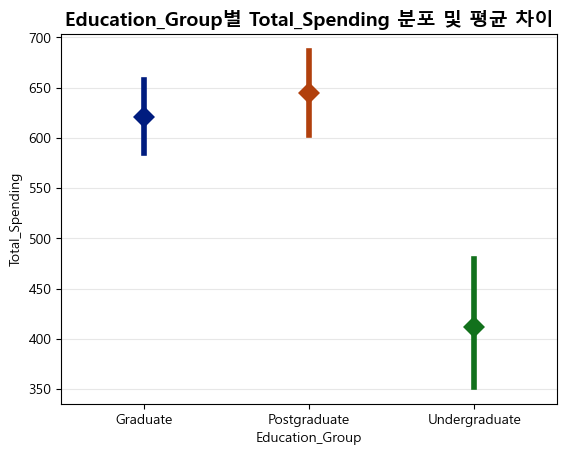

In [103]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
sns.pointplot(x='Education_Group', y='Total_Spending', data=df, 
              join=False, palette='dark', markers='D', scale=1.5, errorbar=('ci', 95), zorder=2)

plt.title('Education_Group별 Total_Spending 분포 및 평균 차이', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [46]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
ct = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

chi2, p_chi2, dof, expected = stats.chi2_contingency(ct)

# Cochran 규칙 확인: 기대빈도 5 미만인 셀의 비율
cells_under_5 = (expected < 5).sum()
total_cells = expected.size
cochran_violation = (cells_under_5 / total_cells) > 0.2

print(f"- Chi-square: {chi2:.4f}, p-value: {p_chi2:.4f}")
print(f"- 기대빈도 5 미만 셀 비율: {cells_under_5/total_cells*100:.1f}%")
print(f"- Cochran 규칙 위반 여부: {'Yes (Fisher 검정 권장)' if cochran_violation else 'No (적합)'}")


# TODO 4-3(b): φ (phi) 계산
n = ct.sum().sum()
phi = np.sqrt(chi2 / n)
print(f"\n Phi: {phi:.4f}")


# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
def calculate_odds_ratio(ct):
    if ct.shape == (2, 2):
        a, b = ct.iloc[0, 1], ct.iloc[0, 0] # Success, Failure (Group 1)
        c, d = ct.iloc[1, 1], ct.iloc[1, 0] # Success, Failure (Group 2)
        
        or_val = (a * d) / (b * c)
        se_ln_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
        ci_low = np.exp(np.log(or_val) - 1.96 * se_ln_or)
        ci_high = np.exp(np.log(or_val) + 1.96 * se_ln_or)
        return or_val, ci_low, ci_high
    return None, None, None

or_val, ci_l, ci_h = calculate_odds_ratio(ct)
if or_val:
    print(f"\n OR: {or_val:.2f} (95% CI: {ci_l:.2f} ~ {ci_h:.2f})")

- Chi-square: 9.2368, p-value: 0.0024
- 기대빈도 5 미만 셀 비율: 0.0%
- Cochran 규칙 위반 여부: No (적합)

 Phi: 0.0643

 OR: 1.35 (95% CI: 1.12 ~ 1.64)


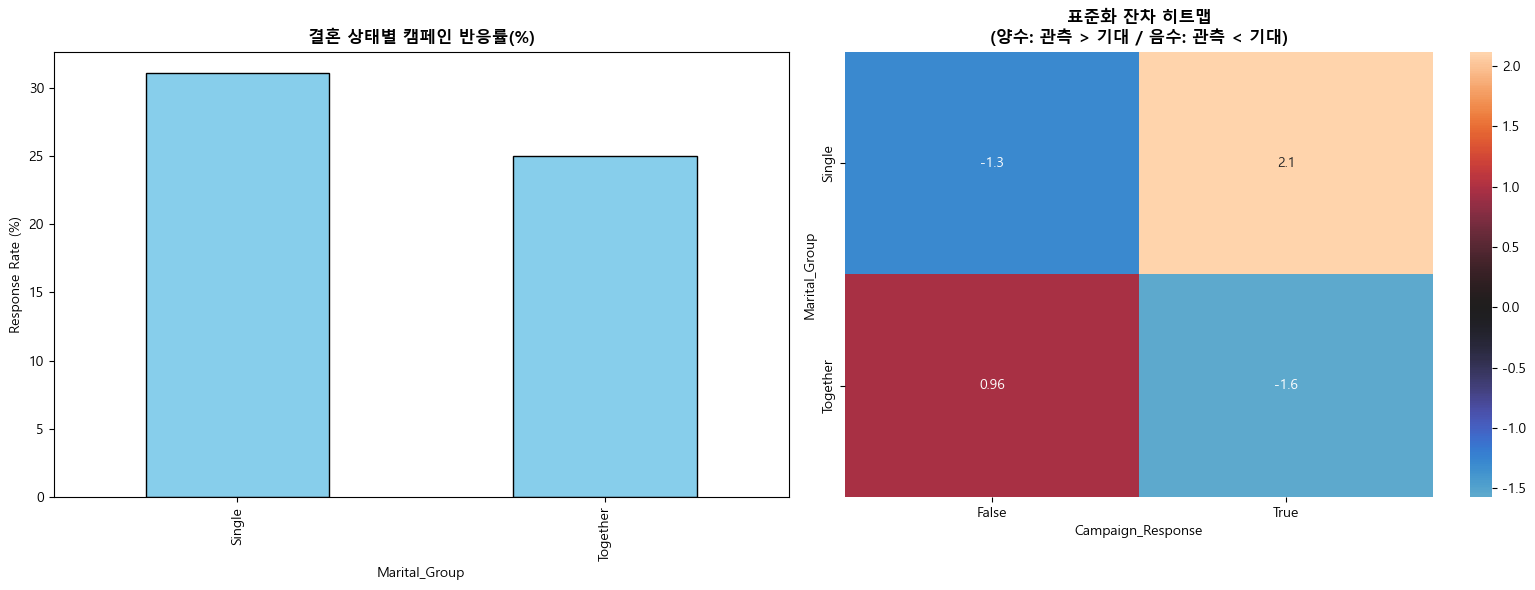

In [50]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

response_rate = ct.div(ct.sum(axis=1), axis=0)[True] * 100
response_rate.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('결혼 상태별 캠페인 반응률(%)', fontweight='bold')
axes[0].set_ylabel('Response Rate (%)')

# (2) 표준화 잔차 히트맵 (Standardized Residuals)
residuals = (ct - expected) / np.sqrt(expected)
sns.heatmap(residuals, annot=True, center=0, ax=axes[1])
axes[1].set_title('표준화 잔차 히트맵\n(양수: 관측 > 기대 / 음수: 관측 < 기대)', fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [82]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
total_purchases = observed.sum()

# 모든 채널의 구매 비율이 1/3로 동일하다는 귀무가설에 따른 기대빈도
expected = np.full(len(observed), total_purchases / len(observed))

# 카이제곱 적합도 검정 수행
chi2_stat, p_val = stats.chisquare(f_obs=observed, f_exp=expected)

for name, obs, exp in zip(channel_names, observed, expected):
    print(f"- {name:7}: 관측={obs:>5}, 기대={exp:>7.1f}")

print(f"\nChi-square Statistic: {chi2_stat:.4f}")
print(f"p-value: {p_val:.4g}")

# 결과 해석
if p_val < 0.05:
    print("결과: 귀무가설 기각 → 채널별 구매 비율이 균등하지 않다.")
else:
    print("결과: 귀무가설 채택 → 채널별 구매 비율이 균등하다.")


# TODO 4-4(b): Cohen's w 계산
p_obs = observed / total_purchases
p_exp = expected / total_purchases

cohen_w = np.sqrt(np.sum((p_obs - p_exp)**2 / p_exp))

print(f"\nCohen's w: {cohen_w:.4f}")

# 효과 크기 가이드라인 (0.1 / 0.3 / 0.5)
if cohen_w < 0.1:
    strength = "매우 작은"
elif cohen_w < 0.3:
    strength = "작은"
elif cohen_w < 0.5:
    strength = "중간"
else:
    strength = "큰"
print(f"해석: 채널 간 불균형의 정도가 {strength} 수준이다.")

- Web    : 관측= 9140, 기대= 9351.3
- Catalog: 관측= 5955, 기대= 9351.3
- Store  : 관측=12959, 기대= 9351.3

Chi-square Statistic: 2630.1063
p-value: 0
결과: 귀무가설 기각 → 채널별 구매 비율이 균등하지 않다.

Cohen's w: 0.3062
해석: 채널 간 불균형의 정도가 중간 수준이다.


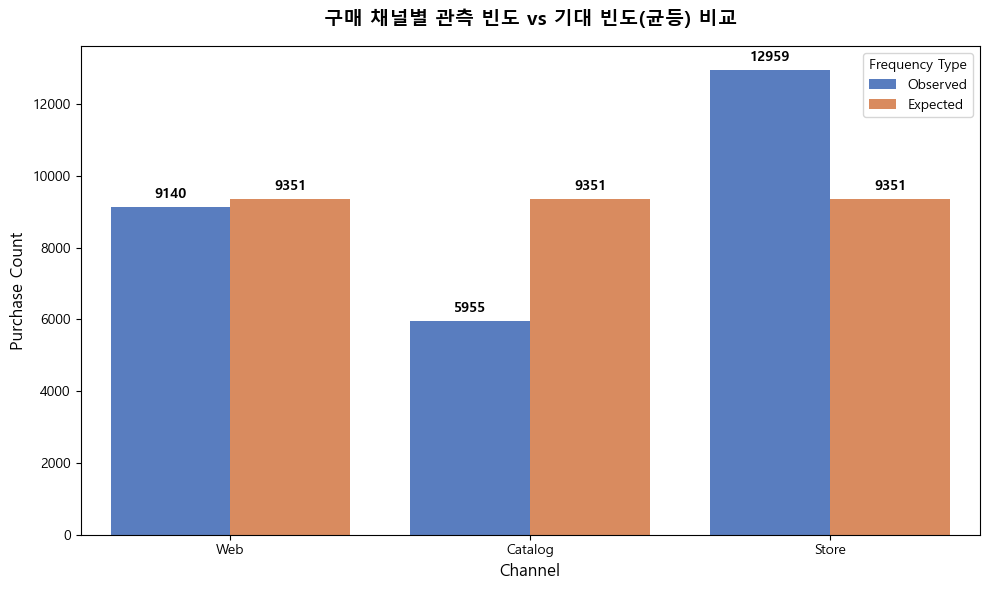

In [55]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
plot_df = pd.DataFrame({
    'Channel': channel_names * 2,
    'Count': np.concatenate([observed, expected]),
    'Type': ['Observed'] * 3 + ['Expected'] * 3
})

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Channel', y='Count', hue='Type', palette='muted')

plt.title('구매 채널별 관측 빈도 vs 기대 빈도(균등) 비교', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Purchase Count', fontsize=12)
plt.xlabel('Channel', fontsize=12)
plt.legend(title='Frequency Type')

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0: # 0보다 큰 경우만 표시
        plt.gca().annotate(f'{int(height)}', 
                           (p.get_x() + p.get_width() / 2., height), 
                           ha='center', va='center', 
                           xytext=(0, 9), 
                           textcoords='offset points',
                           fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

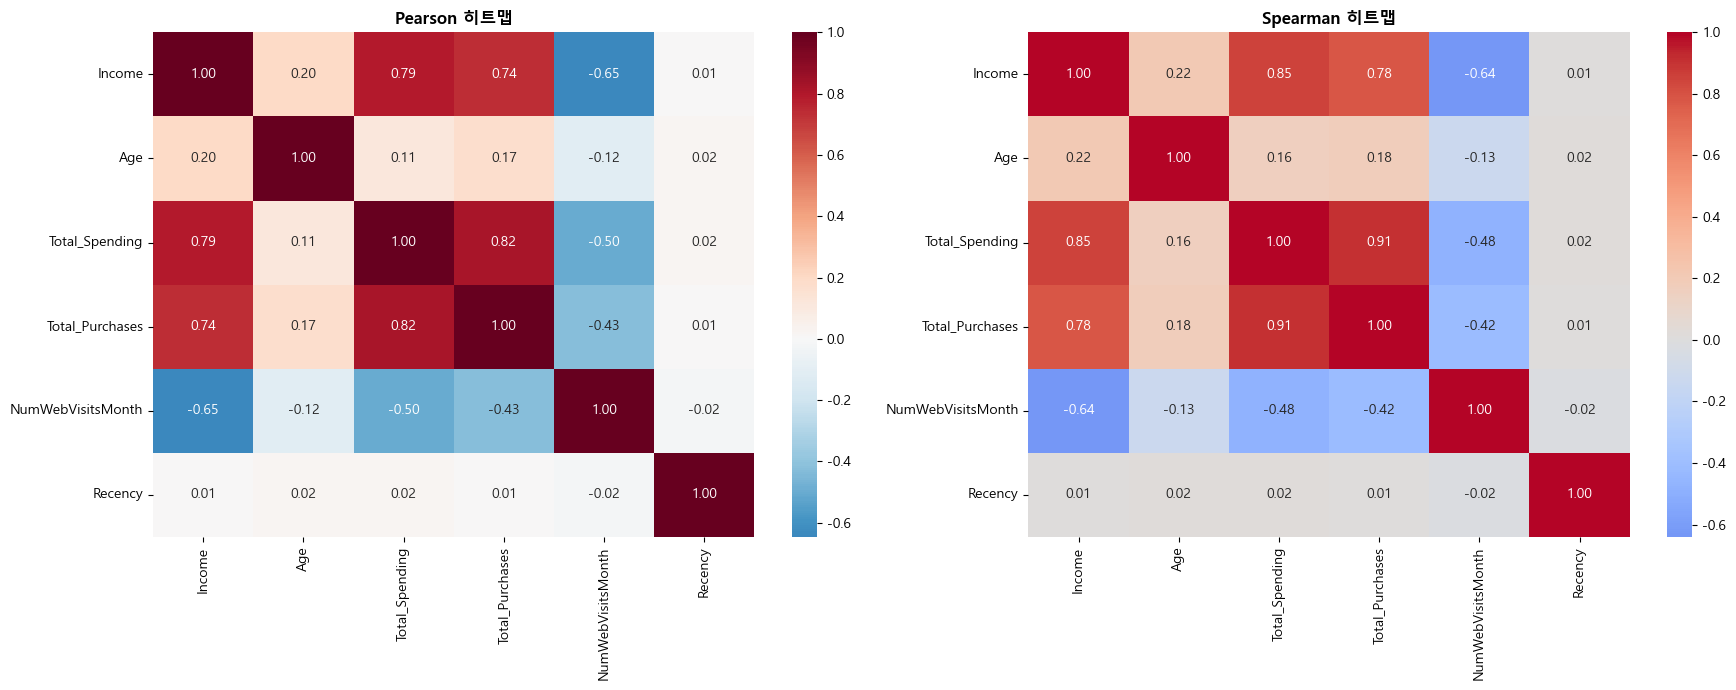

[Income vs Total_Spending]
  Pearson r: 0.7894, p-value: 0
  => 통계적으로 유의미한 강한 양(+)의 상관관계가 있다.
--------------------------------------------------
[Income vs Total_Purchases]
  Pearson r: 0.7386, p-value: 0
  => 통계적으로 유의미한 강한 양(+)의 상관관계가 있다.
--------------------------------------------------
[NumWebVisitsMonth vs Total_Spending]
  Pearson r: -0.4999, p-value: 1.073e-141
  => 통계적으로 유의미한 중간 음(-)의 상관관계가 있다.
--------------------------------------------------


In [60]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
pearson_corr = df[corr_vars].corr(method='pearson')
spearman_corr = df[corr_vars].corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Pearson 히트맵
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='RdBu_r', center=0, ax=axes[0])
axes[0].set_title('Pearson 히트맵', fontweight='bold')

# Spearman 히트맵
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Spearman 히트맵', fontweight='bold')

plt.tight_layout()
plt.show()


# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
test_pairs = [
    ('Income', 'Total_Spending'),
    ('Income', 'Total_Purchases'),
    ('NumWebVisitsMonth', 'Total_Spending')
]


for var1, var2 in test_pairs:
    # 결측치가 있으면 pearsonr이 정상 작동하지 않으므로 dropna() 처리
    temp_df = df[[var1, var2]].dropna()
    r, p_val = stats.pearsonr(temp_df[var1], temp_df[var2])
    
    print(f"[{var1} vs {var2}]")
    print(f"  Pearson r: {r:.4f}, p-value: {p_val:.4g}")
    
    # 해석
    if p_val < 0.05:
        strength = "강한" if abs(r) > 0.7 else "중간" if abs(r) > 0.3 else "약한"
        direction = "양(+)" if r > 0 else "음(-)"
        print(f"  => 통계적으로 유의미한 {strength} {direction}의 상관관계가 있다.")
    else:
        print("  => 통계적으로 유의미한 관계가 발견되지 않았다.")
    print("-" * 50)

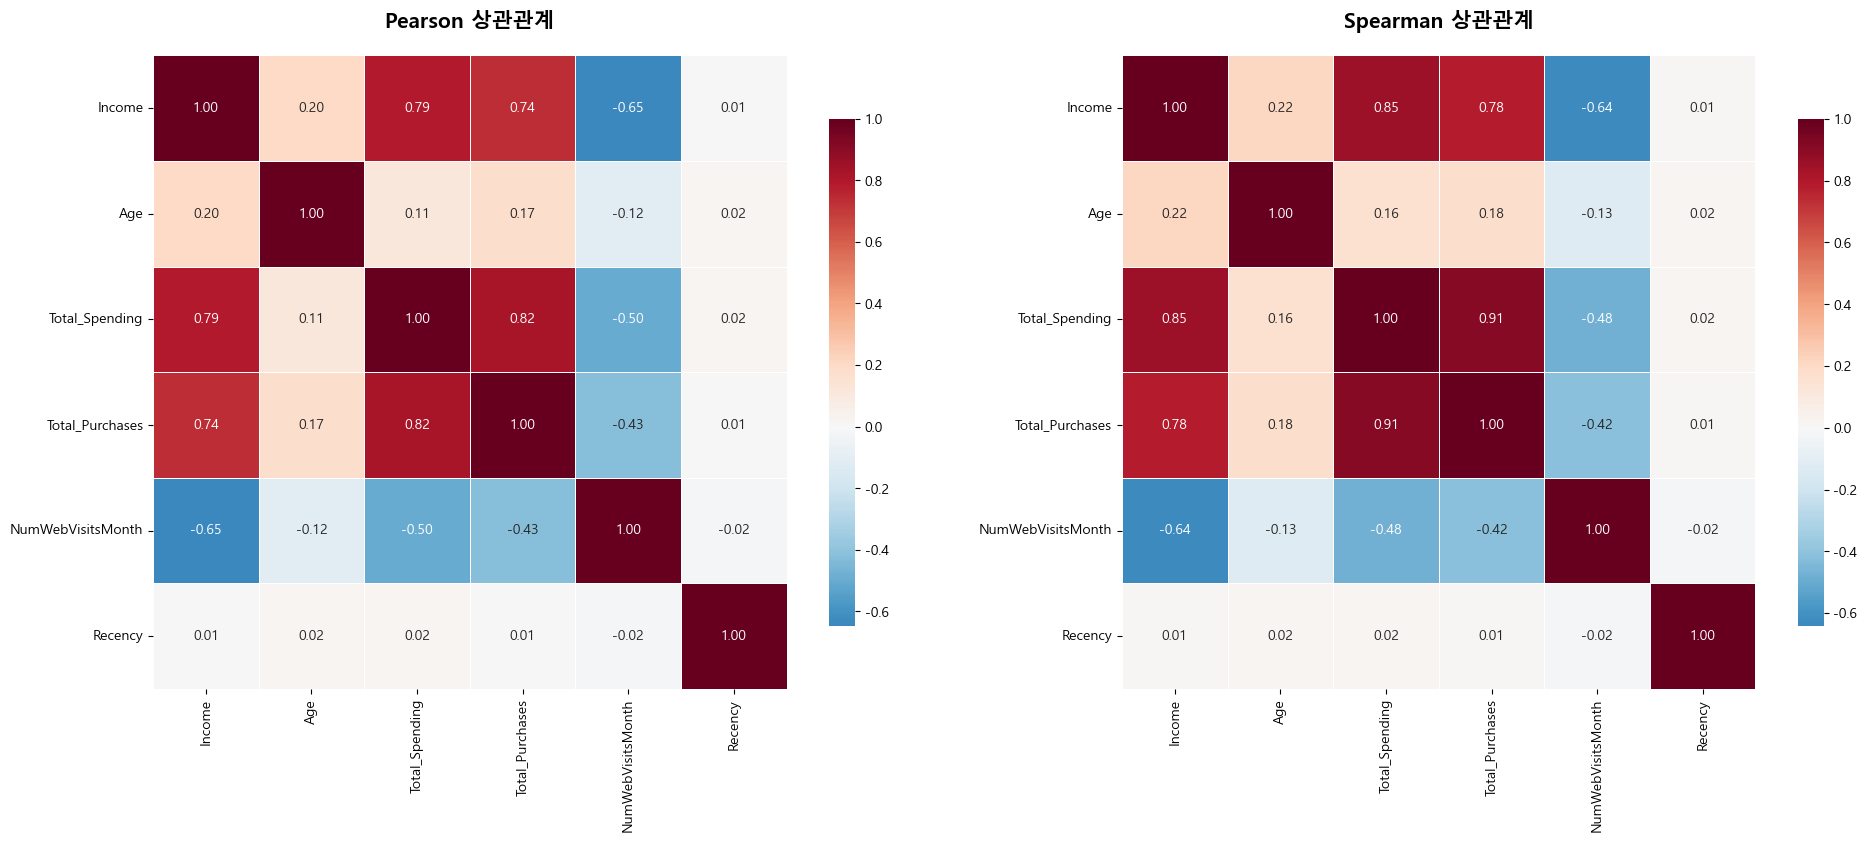

In [62]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

heatmap_kwargs = {
    'annot': True, 
    'fmt': ".2f", 
    'cmap': 'RdBu_r', 
    'center': 0, 
    'square': True, 
    'linewidths': .5,
    'cbar_kws': {"shrink": .8}
}


sns.heatmap(pearson_corr, ax=axes[0], **heatmap_kwargs)
axes[0].set_title('Pearson 상관관계', fontsize=15, fontweight='bold', pad=20)

sns.heatmap(spearman_corr, ax=axes[1], **heatmap_kwargs)
axes[1].set_title('Spearman 상관관계', fontsize=15, fontweight='bold', pad=20)


plt.tight_layout()
plt.show()

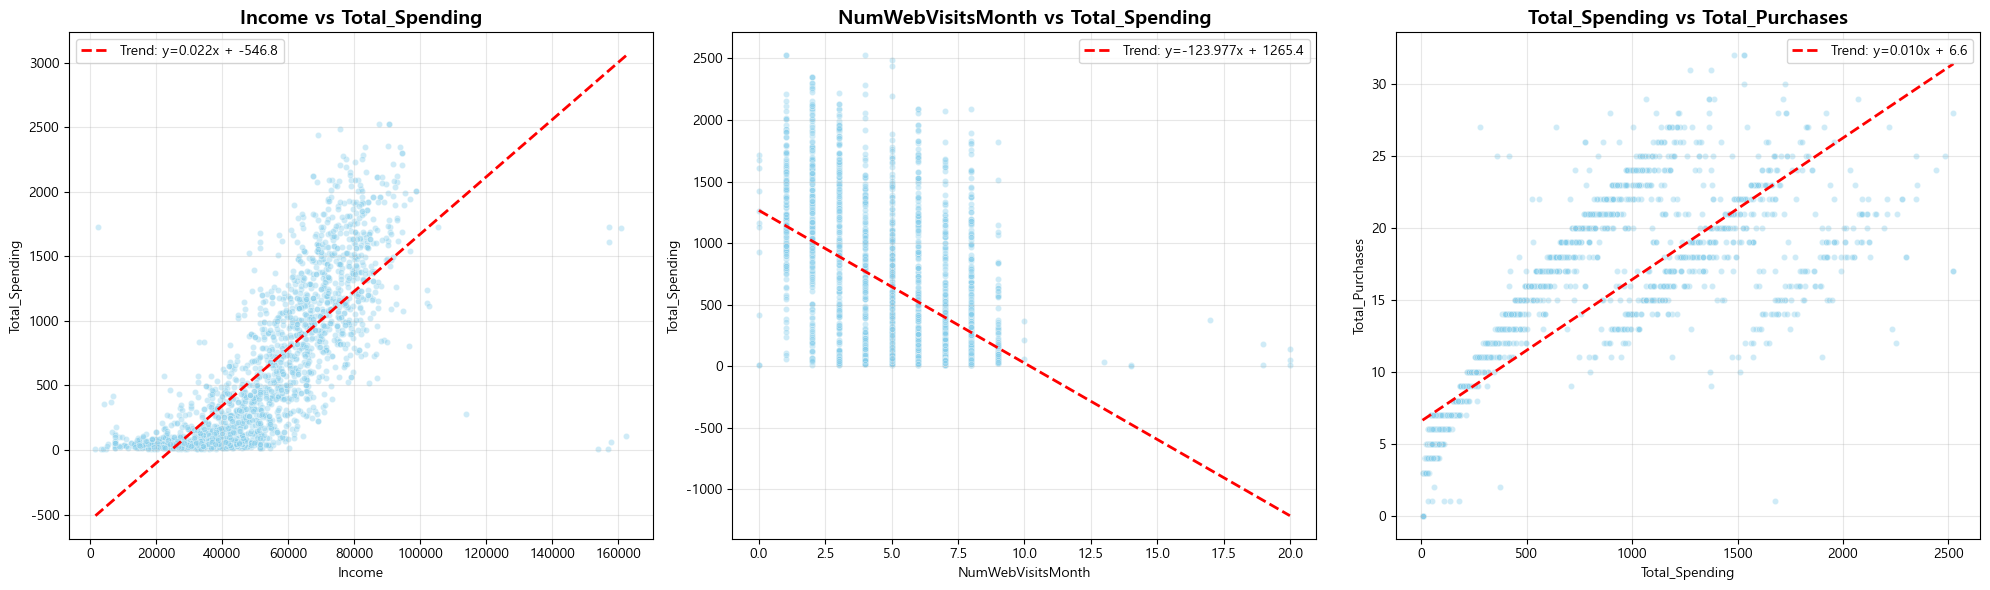

In [64]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

scatter_pairs = [
    ('Income', 'Total_Spending'),
    ('NumWebVisitsMonth', 'Total_Spending'),
    ('Total_Spending', 'Total_Purchases')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (x_col, y_col) in enumerate(scatter_pairs):
    temp_df = df[[x_col, y_col]].dropna()
    x = temp_df[x_col].values
    y = temp_df[y_col].values
    
    axes[i].scatter(x, y, alpha=0.4, s=20, color='skyblue', edgecolors='white', linewidth=0.5)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    x_range = np.linspace(x.min(), x.max(), 100)
    axes[i].plot(x_range, p(x_range), color="red", linestyle="--", linewidth=2, 
                 label=f'Trend: y={z[0]:.3f}x + {z[1]:.1f}')
    
    axes[i].set_title(f'{x_col} vs {y_col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [83]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
counts = np.array([conv_b, conv_a])
nobs = np.array([n_b, n_a])

# z_stat, p_val 계산 (양측 검정)
z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')

print(f"Group A (경험 없음) 수락률: {rate_a:.4f}")
print(f"Group B (경험 있음) 수락률: {rate_b:.4f}")
print(f"Z-statistic: {z_stat:.4f}, p-value: {p_val:.4g}")


# TODO 5-2(b): Cohen's h 효과 크기
h = proportion_effectsize(rate_b, rate_a)

print(f"\nCohen's h: {h:.4f}")

# 해석 기준: 0.2(작음), 0.5(중간), 0.8(큼)
h_abs = abs(h)
if h_abs < 0.2: strength = "매우 작은"
elif h_abs < 0.5: strength = "작은"
elif h_abs < 0.8: strength = "중간"
else: strength = "큰"
print(f"해석: 두 그룹 간 반응 차이의 강도는 {strength} 수준이다.")

# TODO 5-2(c): Wilson 신뢰구간
ci_a = proportion_confint(conv_a, n_a, alpha=0.05, method='wilson')
ci_b = proportion_confint(conv_b, n_b, alpha=0.05, method='wilson')

print(f"\nGroup A (경험 없음): [{ci_a[0]:.4f}, {ci_a[1]:.4f}]")
print(f"Group B (경험 있음): [{ci_b[0]:.4f}, {ci_b[1]:.4f}]")

Group A (경험 없음) 수락률: 0.0823
Group B (경험 있음) 수락률: 0.4069
Z-statistic: 17.4357, p-value: 4.422e-68

Cohen's h: 0.8016
해석: 두 그룹 간 반응 차이의 강도는 큰 수준이다.

Group A (경험 없음): [0.0704, 0.0960]
Group B (경험 있음): [0.3631, 0.4523]


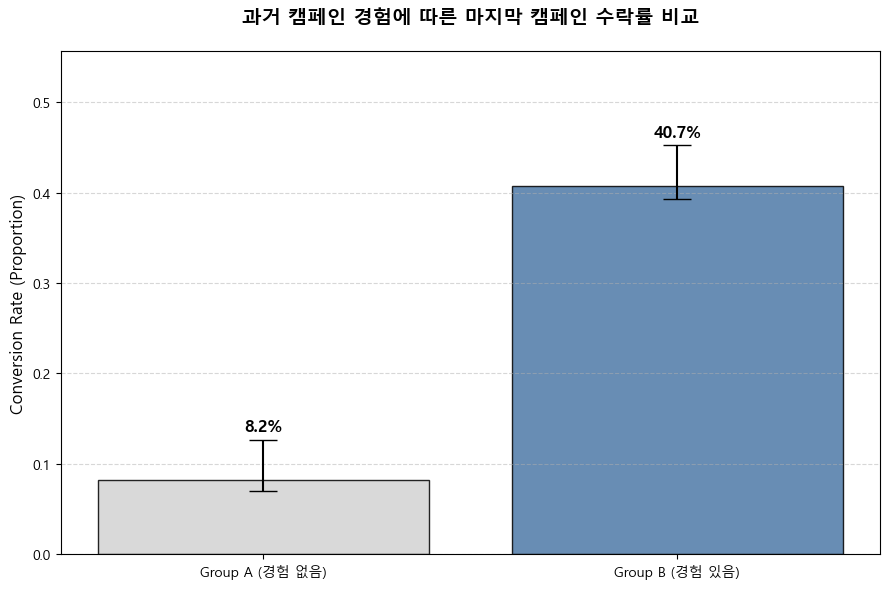

In [86]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
labels = ['Group A (경험 없음)', 'Group B (경험 있음)']
rates = [rate_a, rate_b]

err_a = [[rate_a - ci_a[0]], [ci_a[1] - rate_a]]
err_b = [[rate_b - ci_b[0]], [ci_b[1] - rate_b]]
yerr = np.array([err_a, err_b]).squeeze()

plt.figure(figsize=(9, 6))
colors = ['#d3d3d3', '#4e79a7']
bars = plt.bar(labels, rates, yerr=yerr, capsize=10, color=colors, alpha=0.85, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('과거 캠페인 경험에 따른 마지막 캠페인 수락률 비교', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Conversion Rate (Proportion)', fontsize=12)
plt.ylim(0, max(rates) + 0.15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [80]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
h = proportion_effectsize(target_rate, baseline_rate)

print(f"Base Rate: {baseline_rate:.4f} -> Target Rate: {target_rate:.4f}")
print(f"Cohen's h: {h:.4f}")


# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
analysis = NormalIndPower()

required_n = analysis.solve_power(
    effect_size = h, 
    alpha = 0.05, 
    power = 0.80, 
    ratio = 1.0, 
    alternative = 'larger'
)

print(f"\n탐지하려는 최소 개선폭(MDE): 2.0%p")
print(f"그룹당 필요한 최소 표본 수: {np.ceil(required_n):.0f}명")
print(f"총 필요 표본 수: {np.ceil(required_n) * 2:.0f}명")

Base Rate: 0.1494 -> Target Rate: 0.1694
Cohen's h: 0.0547

탐지하려는 최소 개선폭(MDE): 2.0%p
그룹당 필요한 최소 표본 수: 4138명
총 필요 표본 수: 8276명


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [85]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

# Income_Group: Low, Mid, High / Has_Children: True, False
group_cols = ['Income_Group', 'Has_Children']
metrics = {
    'ID': 'count',
    'Income': 'mean',
    'Total_Spending': ['mean', 'median'],
    'Total_Purchases': 'mean',
    'Response': 'mean',
    'NumWebVisitsMonth': 'mean'
}

analysis_table = df.groupby(group_cols).agg(metrics)

# 컬럼명 정리
analysis_table.columns = [
    'Customer_Count', 'Avg_Income', 'Avg_Spending', 
    'Median_Spending', 'Avg_Purchases', 'Response_Rate', 'Avg_Web_Visits'
]

# 결과 출력
print("[고객 그룹별 특성 분석 종합표]")
display(analysis_table.sort_values(by='Avg_Spending', ascending=False))

[고객 그룹별 특성 분석 종합표]


Customer_Count    Avg_Income  Avg_Spending  \
Income_Group Has_Children                                               
High         False                    442  78697.963801   1424.024887   
             True                     303  71841.607261   1033.115512   
Mid          False                     80  52209.631250    721.237500   
             True                     665  51466.093985    426.254135   
Low          False                    115  24380.243478    145.008696   
             True                     631  29172.879556     86.686212   

                           Median_Spending  Avg_Purchases  Response_Rate  \
Income_Group Has_Children                                                  
High         False                  1383.0      19.219457       0.321267   
             True                   1005.0      19.178218       0.102310   
Mid          False                   653.0      15.362500       0.187500   
             True                    368.0      12.338346       0.090226   
Low          False                    73.0       6.400000       0.104348   
             True                     54.0       5.670365       0.117274   

                           Avg_Web_Visits  
Income_Group Has_Children                  
High         False               2.366516  
             True                4.679868  
Mid          False               4.675000  
             True                5.869173  
Low          False               6.930435  
             True                6.901743

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [91]:
# TODO C-2: 비즈니스 제안서 작성
print("타겟 고객: 소득이 많으면서 아이가 없는 고객군")
print("→ Avg_Purchases가 높고, Response_Rate 또한 높기 때문에")

print("\n채널 전략:")
print("High - 오프라인")
print("Mid - 오프라인 + 온라인")
print("Low - 온라인")

print("\n기대 효과: 캠페인 수락률을 올릴 수 있고, 매출액 증대가 가능하며, 그룹별 마케팅 방식을 달리하면서 마케팅 비용을 줄일 수 있다.")

타겟 고객: 소득이 많으면서 아이가 없는 고객군
→ Avg_Purchases가 높고, Response_Rate 또한 높기 때문에

채널 전략:
High - 오프라인
Mid - 오프라인 + 온라인
Low - 온라인

기대 효과: 캠페인 수락률을 올릴 수 있고, 매출액 증대가 가능하며, 그룹별 마케팅 방식을 달리하면서 마케팅 비용을 줄일 수 있다.


---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛